In [28]:
from IPython.display import display_html
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import warnings

warnings.filterwarnings('ignore')

### Intro

In [29]:
h1 = pd.read_csv('data/H1.csv')
h2 = pd.read_csv('data/H2.csv')

In [30]:
h1.loc[:, 'id'] = range(1, len(h1) + 1)

start = h1['id'].max() + 1
stop = start + len(h2)
h2.loc[:, 'id'] = range(start, stop)

In [31]:
df = pd.concat([h1, h2], ignore_index=True, sort=False)

In [32]:
df.columns[:3]

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear'], dtype='object')

#### Convert to `snake_case`

In [33]:
def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [34]:
columns = [convert(col) for col in df.columns]
df.columns = columns

#### Descriptive statistics

In [35]:
# check the number of examples (rows) and features (columns)
df.shape

(119390, 32)

In [36]:
# first row of the data frame
df.loc[0]

is_canceled                                      0
lead_time                                      342
arrival_date_year                             2015
arrival_date_month                            July
arrival_date_week_number                        27
arrival_date_day_of_month                        1
stays_in_weekend_nights                          0
stays_in_week_nights                             0
adults                                           2
children                                         0
babies                                           0
meal                                     BB       
country                                        PRT
market_segment                              Direct
distribution_channel                        Direct
is_repeated_guest                                0
previous_cancellations                           0
previous_bookings_not_canceled                   0
reserved_room_type                C               
assigned_room_type             

In [37]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,3
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,4
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,5


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 non-null object
is_repeated_guest                 119390 n

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.00,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.00,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.00,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.00,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.00,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.00,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.00,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.00,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.00,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.00,10.0


<a id='rule1'>RULE-1</a>
- Meal types
    - Undefined/SC = No meal package
    - BB = Bed & Breakfast
    - HB = Half board (Breakfast and one other meal – usually dinner)
    - FB = Full board (Breakfast, lunch and dinner)

In [40]:
# for detailed info: https://www.sciencedirect.com/science/article/pii/S2352340918315191
df.meal.unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'Undefined'],
      dtype=object)

In [41]:
df.country.unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', nan, 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'E

- Customer Types
    - Contract: When the booking has an allotment or other type of contract associated to it
    - Group: When the booking is associated to a group
    - Transient: When the booking is not part of a group or contract, and is not associated to other transient booking
    - Transient-party: When the booking is transient, but is associated to at least other transient booking

In [42]:
df.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

<a id='rule2'>RULE-2</a>
<br>
<br>
The PMS assured no missing data exists in its database tables. However, in some categorical variables like `Agent` or `Company`, `NULL` is presented as one of the categories. This should not be considered a missing value, but rather as *not applicable*. For example, if a booking `Agent` is defined as `NULL` it means that the booking did not came from a travel agent.

In [43]:
df.groupby('company') \
    .size() \
    .reset_index() \
    .rename(columns={0: 'bookings'}) \
    .sort_values(by='bookings', ascending=False)

,company,bookings
352,NULL,112593
20,40,927
131,223,784
37,67,267
23,45,250
...,...,...
172,284,1
175,288,1
281,425,1
1,8,1


In [44]:
df.groupby('agent') \
    .size() \
    .reset_index() \
    .rename(columns={0: 'bookings'}) \
    .sort_values(by='bookings', ascending=False)

,agent,bookings
8,9,31961
333,NULL,16340
173,240,13922
0,1,7191
13,14,3640
...,...,...
200,280,1
298,444,1
299,446,1
199,278,1


### Preprocessing

#### Convert `NULL` or `Undefined` string to `np.nan`

In [45]:
for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan

In [46]:
df.isnull().sum()

is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                1169
country                              488
market_segment                         2
distribution_channel                   5
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_

#### Delete some missing values

In [47]:
subset = [
    'country', 
    'children', 
    'market_segment', 
    'distribution_channel',
]
df = df.dropna(subset=subset)

#### Fill missing values by rule-set
[Meal type](#rule1)<br>
[Agent and company](#rule2)

In [48]:
df.loc[df.agent.isnull(), 'agent'] = 999
df.loc[df.company.isnull(), 'company'] = 999
df.loc[df.meal.isnull(), 'meal'] = 'SC'

#### Cleaning wrong values

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,118897.0,0.371355,0.483169,0.00,0.0,0.0,1.0,1.0
lead_time,118897.0,104.311446,106.903759,0.00,18.0,69.0,161.0,737.0
arrival_date_year,118897.0,2016.157666,0.707454,2015.00,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,118897.0,27.166548,13.590028,1.00,16.0,28.0,38.0,53.0
arrival_date_day_of_month,118897.0,15.800971,8.780305,1.00,8.0,16.0,23.0,31.0
stays_in_weekend_nights,118897.0,0.928888,0.996215,0.00,0.0,1.0,2.0,16.0
stays_in_week_nights,118897.0,2.502141,1.900175,0.00,1.0,2.0,3.0,41.0
adults,118897.0,1.858390,0.578578,0.00,2.0,2.0,2.0,55.0
children,118897.0,0.104199,0.399166,0.00,0.0,0.0,0.0,10.0
babies,118897.0,0.007948,0.097381,0.00,0.0,0.0,0.0,10.0


In [50]:
df = df[df.adr > 0]

#### Outlier Detection

##### IQR

In [51]:
cleaned = df.copy()

columns = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'adr',
]

for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f'Lower point: {round(lower, 2)} \t upper point: {round(upper, 2)} \t {col}')
    
    if lower == upper:
        continue
    
    cond1 = (cleaned[col] >= lower) & (cleaned[col] <= upper)
    cond2 = cleaned[col].isnull()
    cleaned = cleaned[cond1 | cond2]

Lower point: -195.5 	 upper point: 376.5 	 lead_time
Lower point: -3.0 	 upper point: 5.0 	 stays_in_weekend_nights
Lower point: -2.0 	 upper point: 6.0 	 stays_in_week_nights
Lower point: 2.0 	 upper point: 2.0 	 adults
Lower point: 0.0 	 upper point: 0.0 	 children
Lower point: 0.0 	 upper point: 0.0 	 babies
Lower point: -11.5 	 upper point: 208.5 	 adr


In [52]:
cleaned[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,106723.0,96.088406,92.822540,0.0,18.0,67.0,152.00,374.0
stays_in_weekend_nights,106723.0,0.865062,0.870129,0.0,0.0,1.0,2.00,4.0
stays_in_week_nights,106723.0,2.318029,1.415296,0.0,1.0,2.0,3.00,6.0
adults,106723.0,1.848083,0.482426,0.0,2.0,2.0,2.00,4.0
children,106723.0,0.083815,0.350265,0.0,0.0,0.0,0.00,3.0
babies,106723.0,0.007534,0.095824,0.0,0.0,0.0,0.00,10.0
adr,106723.0,99.155196,38.421950,1.0,71.1,94.8,123.14,208.5


##### Local Outlier Factor
- Some observations may not be outlier when alone
- However, when combined with another variable, outlier values may occur 
- For example, with the price - nights 
- 70 euro is not a normal price for 7 nights

In [53]:
# thats not important, just for visualization
def display_side_by_side(*args):
    html_str = ''
    
    for df in args:
        html_str += df.to_html()
        
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

In [54]:
cleaned.loc[:, 'total_nights'] = cleaned['stays_in_week_nights'] + cleaned['stays_in_weekend_nights']
cleaned.loc[:, 'price'] = cleaned['adr'] * cleaned['total_nights']

In [55]:
cols = ['total_nights', 'price']

In [56]:
# convert to numpy array, because local outlier method want this
X = np.array(cleaned[cols])

In [57]:
# create model
lof = LocalOutlierFactor(contamination=0.001)

In [58]:
# predictions
y_pred = lof.fit_predict(X)

- Observations predicted as anomalies have values of -1 in predictions 
- These observations have LOF scores less than the threshold 
- Sklearn outputs negative LOF values
<br>&nbsp;
- The below code plots LOF scores as red circles around points
- The larger the LOF, the greater the radius of the circle, and the more anomalous the observation
- And plots outliers in second graph

In [59]:
# predictions (-1: outlier, 1: normal)
anomalies = X[y_pred == -1]

In [60]:
# radius for red circles
X_score = lof.negative_outlier_factor_
radius = (X_score.max() - X_score) / (X_score.max() - X_score.min())

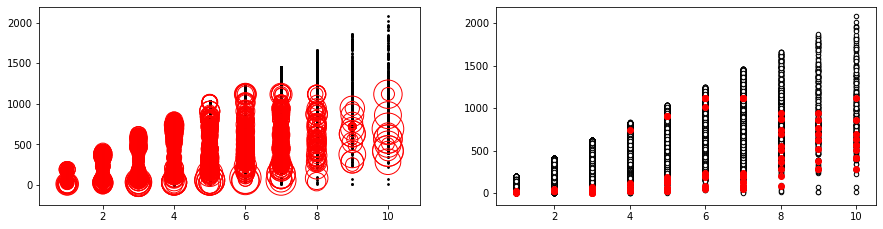

In [61]:
# plot circles and outlier observations
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], color='k', s=3);
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r', facecolors='none')

plt.subplot(2, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
plt.scatter(anomalies[:, 0], anomalies[:,1], c='red');

In [62]:
# statistics of outlier observations
outliers = cleaned[y_pred == -1][cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})

In [63]:
# statistics of all observations
all_data = cleaned[cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})

In [64]:
# statistics of cleaned data
clean_data = cleaned[y_pred != -1] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})

In [65]:
display_side_by_side(all_data, outliers, clean_data)

price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.00 
 208.00 
 93.551632 
 40.041280 
 89.000 
 
 
 2 
 2.00 
 417.00 
 193.363506 
 71.809371 
 187.200 
 
 
 3 
 3.00 
 624.99 
 307.502708 
 108.518262 
 291.600 
 
 
 4 
 4.00 
 834.00 
 402.891749 
 149.940802 
 384.200 
 
 
 5 
 8.00 
 1040.00 
 528.015487 
 196.280852 
 501.500 
 
 
 6 
 36.00 
 1249.02 
 655.874750 
 249.239448 
 635.550 
 
 
 7 
 9.03 
 1459.36 
 666.379208 
 305.362646 
 598.500 
 
 
 8 
 16.00 
 1664.16 
 832.900760 
 362.480690 
 795.600 
 
 
 9 
 14.04 
 1867.50 
 1002.631601 
 409.619361 
 909.765 
 
 
 10 
 18.00 
 2082.00 
 993.092523 
 418.914945 
 921.000 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 9.00 
 24.00 
 14.160000 
 5.833352 
 13.000 
 
 
 2 
 28.00 
 48.00 
 35.200000 
 9.230385 
 30.000 
 
 
 3 
 6.00 
 72.00 
 36.950000 
 22.179290 
 39.000 
 
 
 4 
 27.60 
 741.20 
 120.320000 
 220.412526 
 36.000 
 
 
 5 
 30.00 
 910.00 
 247.230000 
 346.971748 
 60.000 
 
 
 6 
 54.00 
 1121.40 
 575.858182 
 505.806513 
 236.640 
 
 
 7 
 54.60 
 1121.40 
 384.291250 
 442.566490 
 188.755 
 
 
 8 
 84.00 
 945.04 
 548.086667 
 283.577293 
 535.880 
 
 
 9 
 286.92 
 945.90 
 600.525000 
 230.479476 
 630.000 
 
 
 10 
 288.00 
 1119.60 
 590.509091 
 235.271594 
 567.000 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.00 
 208.00 
 93.572076 
 40.026072 
 89.00 
 
 
 2 
 2.00 
 417.00 
 193.395204 
 71.781551 
 187.20 
 
 
 3 
 3.00 
 624.99 
 307.631018 
 108.382895 
 291.60 
 
 
 4 
 4.00 
 834.00 
 403.063160 
 149.736067 
 384.52 
 
 
 5 
 8.00 
 1040.00 
 528.595463 
 195.474883 
 501.50 
 
 
 6 
 36.00 
 1249.02 
 656.128624 
 248.110712 
 635.70 
 
 
 7 
 9.03 
 1459.36 
 666.940786 
 304.807564 
 598.50 
 
 
 8 
 16.00 
 1664.16 
 836.187077 
 362.092116 
 797.24 
 
 
 9 
 14.04 
 1867.50 
 1014.253179 
 407.974964 
 933.21 
 
 
 10 
 18.00 
 2082.00 
 1007.377742 
 417.098617 
 939.20

In [66]:
df_cleaned = cleaned[y_pred != -1].copy()

In [68]:
h1_cleaned = df_cleaned[df_cleaned.id.isin(h1.id.tolist())]
h2_cleaned = df_cleaned[df_cleaned.id.isin(h2.id.tolist())]

h1_cleaned = h1_cleaned.drop('id', axis=1)
h2_cleaned = h2_cleaned.drop('id', axis=1)

In [69]:
h1_cleaned.to_csv('./data/H1_cleaned.csv', index=False)
h2_cleaned.to_csv('./data/H2_cleaned.csv', index=False)